In [75]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import datetime

def categorize(x):
    if x <= 30: return 0
    elif x <= 50: return 1
    else: return 2

def preprocess_3h(df):

    x = df.copy()

    x['category'] = x['Kp*10'].apply(categorize)

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 65)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,Lg_Dst,Kp*10,KpH,AE,lg(AE),ULFgr,lg(ULFgr),ULFgeo,lg(ULFgeo),ULFimf,lg(ULFimf),ULFden,lg(ULFden),B_rtn_r,B_rtn_t,B_rtn_n,B_x,B_gse_y,B_gse_z,B_gsm_y,B_gsm_z,B_magn,SW_spd,SW_spd_Clip290,H_den_SWP,lg(H_den_SWP),He_ratio_SWP,lg(He_ratio),Trr_SWP,lg(Trr),p=n*v*v/2,lg(p),Bs,vBs,E=vBmagn,?c=arctan(By/Bz),?2,E_KL,E_KLV,E_WAV,E_TL,dФ_MP/dt,E>0.8 MeV,"lg(E>0,8 MeV)",E>2 MeV,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,2.056905,13,13.0,97.0,1.986772,2.97,0.472756,1.03,0.012837,NaN,NaN,NaN,NaN,-0.5200,-2.8146,-0.4584,0.5109,2.7669,-0.6968,2.5359,-1.3079,2.9758,314.1321,314.1321,12.9222,1.111336,0.0048,-2.318759,19301.0,4.285580,637574.7335,5.804531,-1.3079,-410.853374,934.794303,-1.094625,204.009280,253.151859,15965.17718,68.556113,20964.85167,774.055916,NaN,NaN,5.191667,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,2.053078,7,11.0,79.0,1.897627,4.26,0.629410,0.29,-0.537602,NaN,NaN,NaN,NaN,-1.7296,-3.4436,-0.0115,1.7186,3.4354,-0.3063,3.0987,-1.5146,3.9844,314.1683,314.1683,8.7635,0.942678,0.0121,-1.917215,17707.0,4.248145,432486.2648,5.635972,-1.5146,-475.839307,1251.772175,-1.116160,392.233359,351.037444,20752.46157,98.442264,25675.02668,985.286740,NaN,NaN,2.082444,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,2.060698,10,8.0,172.0,2.235528,3.83,0.583199,0.99,-0.004365,NaN,NaN,NaN,NaN,0.3850,-2.0324,1.0187,-0.3912,2.1110,0.8411,2.2552,-0.2791,3.3428,311.0230,311.0230,14.8348,1.171282,0.0031,-2.508638,27439.0,4.438368,717524.4626,5.855837,-0.2791,-86.806519,1039.687684,-1.447664,668.542982,455.995881,29232.40459,199.994909,105077.64120,1569.908344,NaN,NaN,1.177167,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,2.053078,10,10.0,54.0,1.732394,3.94,0.595496,0.50,-0.301030,0.38,-0.420216,0.95,-0.022276,0.7018,-2.1733,0.5781,-0.7086,2.2126,0.3898,2.0875,-0.8307,2.5349,308.0456,308.0456,15.8484,1.199985,0.0044,-2.356547,27392.0,4.437624,751943.9129,5.876185,-0.8307,-255.893480,780.864791,-1.192067,196.569412,246.073855,15847.76606,77.545233,29967.63429,829.430645,NaN,NaN,3.173833,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,2.041393,7,9.0,150.0,2.176091,7.65,0.883661,0.20,-0.698970,0.30,-0.522879,NaN,NaN,3.7120,-2.3427,1.7193,-3.7192,2.4701,1.5132,2.8925,0.1565,4.7589,300.7700,300.7700,13.3870,1.126683,0.0069,-2.161151,27376.0,4.437370,605511.3656,5.782122,0.0000,0.000000,1431.334353,1.516744,1523.862187,677.002238,41721.05925,320.213114,166672.62320,2101.111435,NaN,NaN,10.257500,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 12:00:00


In [92]:
categories = list(sorted(df.category.unique()))

In [93]:
categories

[0, 1, 2]

In [78]:
df = df[['category', 'Kp*10', 'dttm']]

In [79]:
def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.shift(lag).add_suffix(column_name))

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).add_suffix(column_name))

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(f'{subset}_{suffix_name}_{index}'))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)

In [80]:
ts_df_back, lag_cols = add_lags(df, lags=24, forward=False, 
                                trim=True, subset='Kp*10', return_cols=True)


In [81]:
ts_df_back_train = ts_df_back.set_index('dttm').last('24m')

index_train = ts_df_back_train.index
ts_df_back_test = ts_df_back.set_index('dttm').drop(index_train)


In [82]:
ts_df_train, lead_cols = add_lags(ts_df_back_train, lags=24 // 3, forward=True, 
                                  trim=True, subset='category', return_cols=True)
ts_df_test, lead_cols = add_lags(ts_df_back_test, lags=24 // 3, forward=True, 
                                 trim=True, subset='category', return_cols=True)

In [83]:
lag_cols.append('Kp*10')

In [84]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(XGBClassifier(random_state=17))

In [85]:
X_train, y_train = ts_df_train[lag_cols], ts_df_train[lead_cols]
X_test, y_test = ts_df_test[lag_cols], ts_df_test[lead_cols]

In [86]:
X_train.shape, X_test.shape

((5664, 25), (65072, 25))

In [87]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(random_state=17))

In [88]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)

In [89]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

In [95]:
confusion_matrices = {
    col: pd.DataFrame(
        confusion_matrix(preds.loc[:, col], y_test.loc[:, col]),
        index=categories, columns=categories)
    for col in lead_cols
}

In [97]:
# В качестве метрики предлагаю F-1 взвешенную

confusion_matrices['category_lead_1']

,0,1,2
0,52583,5224,194
1,1939,4017,1060
2,6,22,27


In [98]:
from sklearn.metrics import f1_score

In [99]:
from types import FunctionType

def columnwise_score(scoring_func: FunctionType, 
                     preds_df: pd.DataFrame, 
                     true_df: pd.DataFrame,
                     **kwargs) -> pd.Series:

    score = pd.Series(dtype='float64')
    for (column_pred, y_pred), (columns_true, y_true) in zip(preds_df.iteritems(), 
                                                             true_df.iteritems()):
        score[column_pred] = scoring_func(y_pred, y_true, **kwargs)
    
    return score

In [100]:
f1_macro_res = columnwise_score(f1_score, preds, y_test, average='macro')

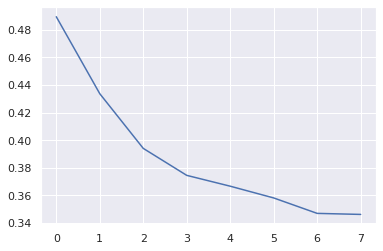

In [101]:
f1_macro_res.sort_index().reset_index(drop=True).plot()

In [102]:
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='weighted')

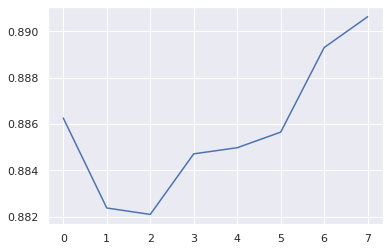

In [103]:
f1_weighted_res.sort_index().reset_index(drop=True).plot()

In [105]:
f1_weighted_res.sort_index()

category_lead_1    0.886259
category_lead_2    0.882376
category_lead_3    0.882098
category_lead_4    0.884714
category_lead_5    0.884978
category_lead_6    0.885651
category_lead_7    0.889304
category_lead_8    0.890634
dtype: float64

In [104]:
f1_macro_res.sort_index()

category_lead_1    0.489502
category_lead_2    0.433712
category_lead_3    0.394066
category_lead_4    0.374509
category_lead_5    0.366654
category_lead_6    0.358136
category_lead_7    0.346948
category_lead_8    0.346196
dtype: float64